# An Unsupervised Approach to MNIST Dataset

The MNIST dataset, first studied by Yann LeCun in 1998 (current Chief Artificial Intelligence Scientist at Facebook AI Research), is a collection of handwritten digits from 0 to 9. Nowadays it is widely used due to its pedagogical value in the context of machine learning classification problems. The goal is to be able to teach a computer how to distinguish between written numbers, and most importantly, to do it with a high degree of generality (for different writting styles, angles, etc.).

Here, an unsupervised approach to MNIST is presented. We will classify the written digits always assuming that nobody took the effort to label each number. A preliminary exploration will be done, together with a dimensional reduction to simplify the problem. Then, k-means will be used to solve the problem.

(The dataset containing 20.000 digits was obtained from Google Colab sample_data.)

### Table of Contents

- [0. Loading the Dataset](#0.-Loading-the-Dataset)
- [1. Analysis of the Dataset](#1.-Analysis-of-the-Dataset)
    - [1.1 Visualizing Written Digits](#1.1-Visualizing-Written-Digits)
    - [1.2 Average of All Written Numbers](#1.2-Average-of-All-Written-Numbers)
    - [1.3 Correlation Matrix](#1.3-Correlation-Matrix)
- [2. Dimensional Reduction: PCA](#2.-Dimensional-Reduction:-PCA)
- [3. Solving the Problem: K-means](#3.-Solving-the-Problem:-K-means)
- [4. Semi-Supervised Case: 100 Labelled Digits](#4.-Semi-Supervised-Case:-100-Labelled-Digits)

## 0. Loading the Dataset

In [1]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import Counter

from sklearn.datasets import load_digits

In [2]:
mnist = pd.read_csv('Datasets/MNIST.csv', header=None)
mnist = np.array(mnist)
print('The shape of the dataset is:',mnist.shape)
print(mnist)

X = mnist[:,1:]
Y = mnist[:,0]

The shape of the dataset is: (20000, 785)
[[6 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]
 [7 0 0 ... 0 0 0]
 ...
 [2 0 0 ... 0 0 0]
 [9 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]]


## 1. Analysis of the Dataset

### 1.1 Visualizing Written Digits

How do the written numbers look like? Well, not surprisingly, like written numbers! They are represented in a 28x28 matrix which is plotted below. The resolution is not great, but it is good enough (and this reduces the computational cost enormously).

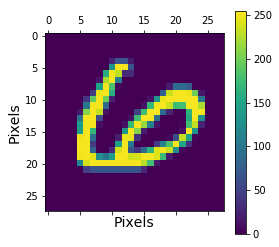

In [2]:
img0 = X[0,:]      #We select the first image

# Reshape and visualization
plt.matshow(img0.reshape(28,28))
plt.colorbar()
plt.xlabel('Pixels',fontsize=14)
plt.ylabel('Pixels',fontsize=14)
plt.show()

### 1.2 Average of All Written Numbers

What if all the images are taken, and the average image is calculated? This is an interesting approach to have an idea about the distribution of pixel activation.

The result can be seen below. We can see that most of the information is concentrated in the center of the image, and even some shapes can be distinguished.

*Note: It is not done here, but we could erase a lot input variables (pixels) that remain inactivated most of the time.*

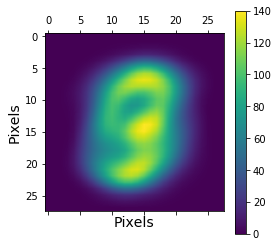

In [3]:
promedios=[np.mean(X[:,i]) for i in range(len(X[0,:]))]
promedios=np.array(promedios)
plt.matshow(promedios.reshape(28,28),cmap='viridis',interpolation='bilinear')
plt.xlabel('Pixels',fontsize=14)
plt.ylabel('Pixels',fontsize=14)
plt.colorbar()
plt.show()

### 1.3 Correlation Matrix

The correlation matrix can give us information about the relation between the different variables of the dataset. From the visualization we can see:
   - Some of the pixels always remain inactivated (white lines that vertically/horizontally cross the plot)
   - The diagonal, of course, represents the auto-correlation.
   - The highly-correlated lines parallel to the diagonal represent the points near to the pixel considered, but not present in the same horizontal line (remember that the pixels come as a 1D array, and the real image is 28x28).

In [4]:
#The matrix is going to find some divisions by zero. We will avoid unncesary warnings
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

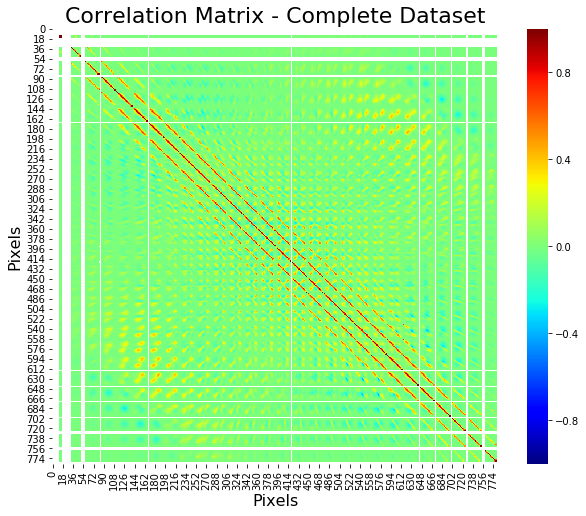

In [5]:
fig=plt.figure(figsize=(10,8))
corr_Matrix=np.corrcoef(X.T)
sb.heatmap(corr_Matrix, vmin = -1, vmax = 1, cmap='jet')
plt.title('Correlation Matrix - Complete Dataset', fontsize=22)
plt.xlabel('Pixels',fontsize=16)
plt.ylabel('Pixels',fontsize=16)
plt.show()

## 2. Dimensional Reduction: PCA

PCA is an algebraic method for dimensional reduction which takes for each PCA-variable a linear combination of variables that result in the direction of maximum variance of the original distrbution. More details [here](http://setosa.io/ev/principal-component-analysis/).

We will choose a subset of PCA-variables that are able to preserve the 50% of the original variance. This results in reducing our system from 784 to 11 variables.

In [6]:
x=X
ipca = PCA(n_components=0.5)
ipca.fit(x)
xt = ipca.transform(x)

print(xt.shape)

(20000, 11)


Another property of PCA is that the different components are perpendicular to each other. This can be seen in the correlation matrix:

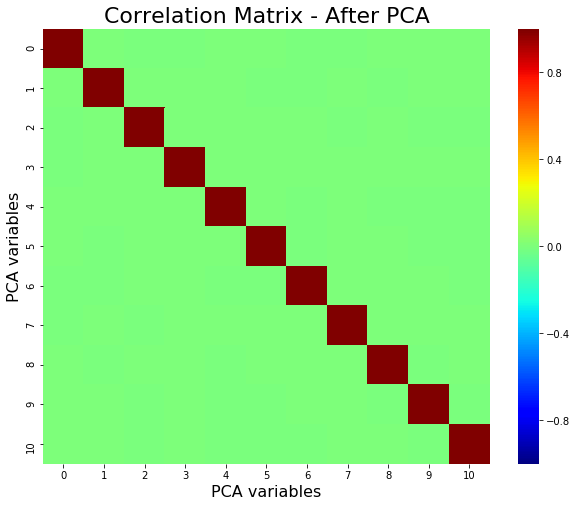

In [7]:
fig=plt.figure(figsize=(10,8))
corr_Matrix=np.corrcoef(xt.T)
sb.heatmap(corr_Matrix, vmin = -1, vmax = 1, cmap='jet')
plt.title('Correlation Matrix - After PCA', fontsize=22)
plt.xlabel('PCA variables',fontsize=16)
plt.ylabel('PCA variables',fontsize=16)
plt.show()

## 3. Solving the Problem: K-means

We will use K-means to clasify our dataset. In order to choose the appropiate number of clusters k, we will use the elbow method. We have to calculate, for different k values, the squared sum of distances of each point to the closest cluster center. Whenever there is an abrupt change in the slope of this curve (towards a flatter slope), 

In [8]:
N=20
codos=[]

for i in range(1,N):     
  clusterer = KMeans(n_clusters=i).fit(xt)
  codos.append(clusterer.inertia_)

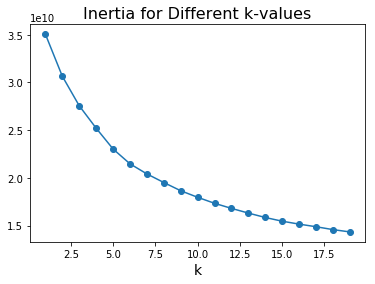

In [9]:
plt.plot(range(1,N),codos, "-o")
plt.title('Inertia for Different k-values',fontsize=16)
plt.xlabel('k',fontsize=14)
plt.show()

As we can see above, there is not much information to gain from the last plot. It will be necessary to find the optimal k with another technique.

Silhouette measures how close each point in one cluster is to points in the neighboring clusters. Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In [10]:
N=20
sil=[]

for i in range(2,N):    #Careful! error for n_clusters=i=1
  clusterer = KMeans(n_clusters=i).fit(xt)
  cluster_labels = clusterer.labels_
  silhouette_avg = silhouette_score(xt, cluster_labels)
  sil.append(silhouette_avg)

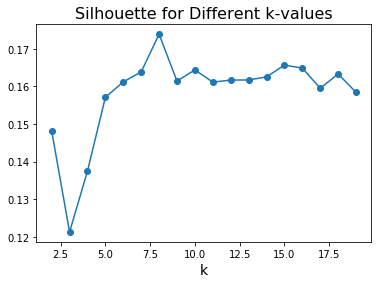

In [11]:
plt.plot(range(2,N),sil, "-o")
plt.title('Silhouette for Different k-values',fontsize=16)
plt.xlabel('k',fontsize=14)
plt.show()

From the previous visualization, we can clearly see that the optimal number of clusters is k=8.

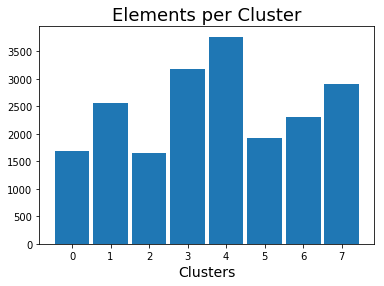

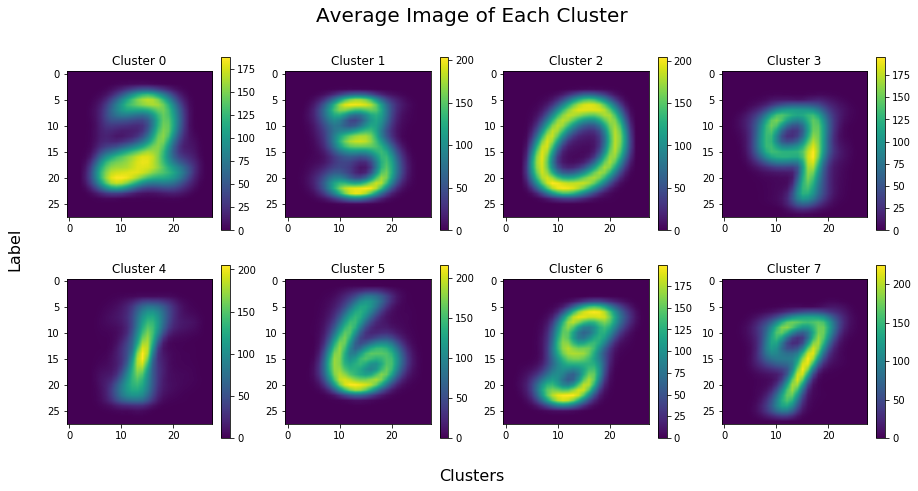

In [35]:
k=8

clustererk = KMeans(n_clusters=k).fit(xt)
clustered=clustererk.labels_

plt.hist(clustered,k,(0,k),rwidth=0.9)
plt.xticks(np.arange(0.5,k,1), np.arange(0, k, 1))
plt.title('Elements per Cluster',fontsize=18)
plt.xlabel('Clusters',fontsize=14)
plt.show()

# RECALL!! These cluster indices do not match (in principle) with the written digit classified.
# To see what number is being classified each time, we will plot the average written digit of each cluster.

clustersizes=[]

fig=plt.figure(figsize=(15,7))

for i in range(k):
  clusteredk = X[clustered==i,:]
  promediok=[np.mean(clusteredk[:,i]) for i in range(len(X[0,:]))]
  promediok=np.array(promediok)
  ax1 = fig.add_subplot(2,k/2,i+1)
  plt.imshow(promediok.reshape(28,28),cmap='viridis',interpolation='bilinear')
  plt.title('Cluster '+str(i))
  plt.colorbar()
plt.suptitle('Average Image of Each Cluster',fontsize=20)
fig.text(0.5, 0.04, 'Clusters', ha='center',fontsize=16)
fig.text(0.07, 0.5, 'Label', va='center', rotation='vertical',fontsize=16)
plt.show()

It has been found out that the optimal number is k=8. Why does this happen? Why is not k=10 found as the optimal value?

Well, digits are human constructs. Since this method only understands about correlations, not digits, our intuition tells us that some highly correlated numbers are clustered together (like 4, 9, 7...). On the other side, it can also be seen that digits written slightly slanted are separated in different clusters (check Clusters 2 and 3). This results in k=8 being the optimal value. Still, if we forced it and chose k=10, we would just obtain cluster based on the same principle: they would not be equal to the human categories.

## 4. Semi-Supervised Case: 100 Labelled Digits

We will assume that we know the labels of 100 written digits (someone took the effort! it is a semi-supervised problem). This allows us to make histograms of labels for each cluster containing labelled digits. In such a way, we can see what numbers are being assigned to each cluster.

We will assign to each cluster the label of the most common known digit.

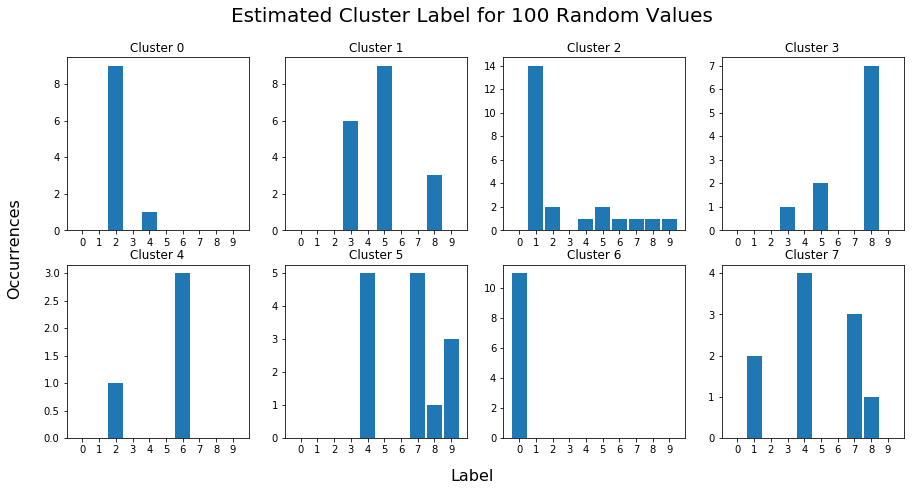


List of labels per cluster: [2, 5, 1, 8, 6, 4, 0, 4]



In [23]:
n=100
knownx = random.sample(range(0,20000), n)

randpred = clustered[knownx]
ClusterNumbering = []

fig=plt.figure(figsize=(15,7))
for i in range(k):
  hist_x=[Y[knownx[s]] for s in range(len(knownx)) if randpred[s]==i]
  ax1 = fig.add_subplot(2,k/2,i+1)
  plt.title('Cluster ' + str(i))
  most_common,num_most_common = Counter(hist_x).most_common(1)[0]   # Find most repeated element in cluster
  ClusterNumbering.append(most_common)    # We assign a label to this cluster
  plt.hist(hist_x,10,(0,10),rwidth=0.9)
  plt.xticks(np.arange(0.5,10,1), np.arange(0, 10, 1))

plt.suptitle('Estimated Cluster Label for ' + str(n) + ' Random Values',fontsize=20)
fig.text(0.5, 0.04, 'Label', ha='center',fontsize=16)
fig.text(0.07, 0.5, 'Occurrences', va='center', rotation='vertical',fontsize=16)
plt.show()
print()

print('List of labels per cluster:',ClusterNumbering)
print()

Finally, in order to test the quality of this classification based on the 100 labeled digits, we will compare the predicted labels with the real ones. This is against the unsupervised assumption! However, we will just use it to test; for our classification we had no information about labels, and afterwards only 100 of the digits were known.

In [31]:
iteraciones=20
totallist=[]

for j in range(iteraciones):
  clustererk = KMeans(n_clusters=k).fit(xt)
  clustered=clustererk.labels_
  
  
  knownx = random.sample(range(0,20000), n)
  randpred = clustered[knownx]
  ClusterNumbering = []
  
  for i in range(k):
    hist_x=[Y[knownx[s]] for s in range(len(knownx)) if randpred[s]==i]
    most_common,num_most_common = Counter(hist_x).most_common(1)[0]    #Error happened when we had 2 identical maximum values - Corrected!
    ClusterNumbering.append(most_common)
  
  c=0
  for i in range(np.shape(X)[0]):
    if Y[i]==ClusterNumbering[clustered[i]]:
      c=c+1

  total=c/np.shape(X)[0]
  totallist.append(total)
  
meantotal=np.mean(totallist)

print('The mean accuracy of our semi-supervised classifier for',n,'labeled digits is',round(meantotal*100,2),'%')

The mean accuracy of our semi-supervised classifier for 100 labeled digits is 53.49 %


As we can see, merely knowing 100 handwritten digits, we are able to classify with an accuracy >50% a dataset of 20,000 digits.

Possible improvements for future versions of this model:
   - Add normalization/standardization
   - Add onehot
   - Add information about the most important variables in PCA
   - Cut digit borders as suggested here to reduce dimensionality